# 1. Table Extraction Model
**Documents Tables Detection** on Marmot dataset using Deep Neural Network.

Following are the libraries that we will import.

In [63]:
import pydot
import graphviz
import tensorflow as tf
from pyhton_local_files.network import TEM
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

## Script for generating mask

In [64]:
!python generate_masks/generate_mask.py

# 2. Load Data
Data is locally available in project folder and we specified the location

In [65]:
data_set = tf.data.Dataset.list_files('./dataset/Marmot_data/*.xml')

In [66]:
data_set

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

# 3. Data Preprocessing 
This code defines functions to preprocess image and mask files for a machine learning task. It includes setting the height and width for image resizing, normalizing input images, decoding and resizing images (BMP and JPEG formats), and processing file paths to read, decode, normalize, and resize images and masks accordingly. The functions normalize input images, decode and resize images and masks, and process file paths to return preprocessed image data and masks ready for further machine learning operations.

In [67]:
# Set the height and width for image resizing
img_height, img_width = 256, 256

# Function to normalize the input image
def normalize(input_img):
    input_img = tf.cast(input_img, tf.float32) / 255.0  # Normalize image pixel values to [0, 1]
    return input_img

# Function to decode and resize the input image
def image_decode(img):
    img = tf.image.decode_bmp(img, channels=4)  # Decode BMP image with 4 channels (RGBA)
    img_resized = tf.image.resize(img, [img_height, img_width])  # Resize image to specified dimensions
    return img_resized

# Function to decode and resize the mask image
def mask_img_decode(img):
    img = tf.image.decode_jpeg(img, channels=1)  # Decode JPEG image with 1 channel (grayscale)
    img_resized = tf.image.resize(img, [img_height, img_width])  # Resize image to specified dimensions
    return img_resized

# Function to process file paths and return preprocessed images and masks
def process_path(file_path):
    # Replace file extensions in file paths
    file_path = tf.strings.regex_replace(file_path, '.xml', '.bmp')
    mask_file_path = tf.strings.regex_replace(file_path, '.bmp', '.jpeg')
    table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
    column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')

    # Read, decode, normalize, and resize the input image and masks
    img = normalize(image_decode(tf.io.read_file(file_path)))
    table_mask = normalize(mask_img_decode(tf.io.read_file(table_mask_file_path)))
    column_mask = normalize(mask_img_decode(tf.io.read_file(column_mask_file_path)))

    # Return preprocessed image and masks
    return img[:, :, :-1], {"table_output": table_mask, "column_output": column_mask}


## Data Pipeline Setup for Machine Learning
 This code sets up the data pipeline for a machine learning task. It calculates the dataset size and splits it into training and testing sets. The training set is further processed by shuffling, mapping through the 'process_path' function, batching, repeating, and prefetching for optimization. The testing set is also mapped through 'process_path' and batched for evaluation. The variables TRAIN_LENGTH, BATCH_SIZE, BUFFER_SIZE, and STEPS_PER_EPOCH are used to configure the training dataset. This code efficiently prepares the data for training and testing machine learning models.

In [68]:
datasetsize = len(list(data_set))
train_size = int(0.9 * datasetsize)
test_size = int(0.1 * datasetsize)

train = data_set.take(train_size)
test = data_set.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

#### Display Images
This function displays images from a list of images provided as input. It creates a plot with subplots for each image in the list, specifying titles for each subplot. The images are converted to displayable format using TensorFlow's 'array_to_img' function from keras.preprocessing.image. The plot is then shown using matplotlib's 'imshow' and 'show' functions. 

In [69]:

def display_image(disp_list, mask_cmap=None):
    plt.figure(figsize=(15, 15))  # Set the figure size

    title = ['Input Image', 'Table Mask', 'Column Mask']  # Define titles for subplots

    for i in range(len(disp_list)):
        plt.subplot(1, len(disp_list), i+1)  # Create subplots
        plt.title(title[i])  # Set subplot title

        if i == 0:  # Input image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(disp_list[i]))
        else:  # Masks
            plt.imshow(disp_list[i], cmap=mask_cmap)  # Change colormap for masks

        plt.axis('off')  # Turn off axis

    plt.show()  # Show the plot


(256, 256, 3)
(256, 256, 1) (256, 256, 1)


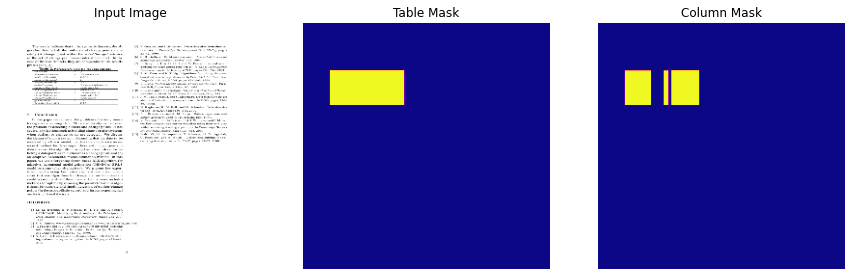

(256, 256, 3)
(256, 256, 1) (256, 256, 1)


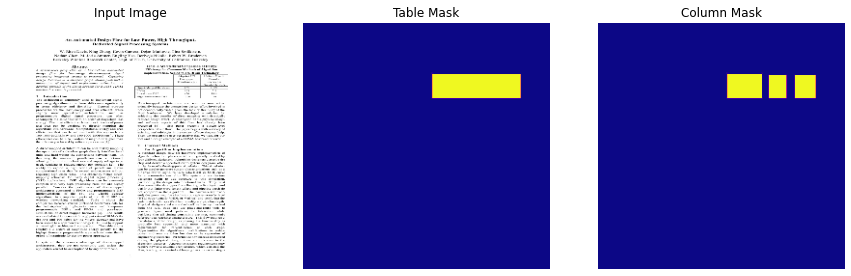

(256, 256, 3)
(256, 256, 1) (256, 256, 1)


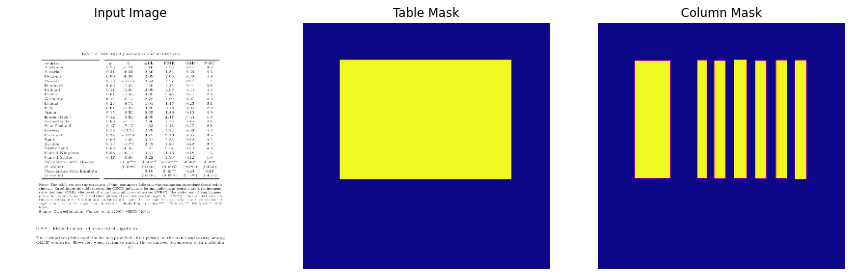

(256, 256, 3)
(256, 256, 1) (256, 256, 1)


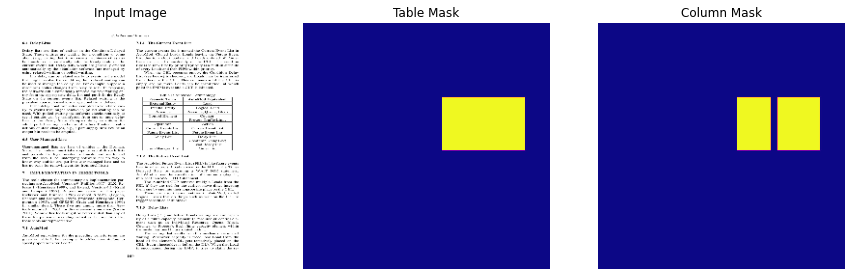

(256, 256, 3)
(256, 256, 1) (256, 256, 1)


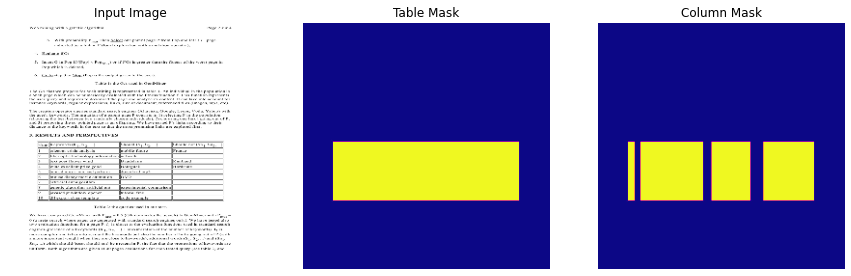

In [70]:
# Here we iterates over the first 5 samples in the training dataset, printing the shapes of the input image and its
# corresponding table and column masks.

for image, mask in train.take(5):
    print(image.shape)  # Print the shape of the input image
    print(mask['table_output'].shape, mask['column_output'].shape)  # Print the shapes of the table and column masks
    
    # Display the input image, table mask, and column mask using the 'display_image' function
    display_image([image, mask['table_output'], mask['column_output']], mask_cmap='plasma')


# 4. TEM Model
Here we encapsulates methods for building a convolutional neural network (CNN) model for table extraction in images. The class includes static methods to construct different parts of the model: `build_table_decoder` and `build_column_decoder` for defining decoder layers specific to table and column masks, `vgg_base` for initializing the base VGG-19 model with specified layers, and `build` to assemble the complete TEM model with input shape and layers interconnected. The model architecture involves convolutional and upsampling layers, dropout for regularization, and concatenation to combine feature maps from different layers. 

In [71]:
class TEM:
  @staticmethod
  def build_table_decoder(inputs, pool3, pool4):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='table_output') 
    
    x = last(x)

    return x

  @staticmethod
  def build_column_decoder(inputs, pool3, pool4):
    
    x = Conv2D(512, (1, 1), activation = 'relu', name='block7_conv1_column')(inputs)
    x = Dropout(0.8, name='block7_dropout_column')(x)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')(x)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='column_output') 
    
    x = last(x)

    return x  

  @staticmethod
  def vgg_base(inputs):
    base_model = tf.keras.applications.vgg19.VGG19(
        input_shape=[256, 256, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)
  
  @staticmethod
  def build():
    inputShape = (256, 256, 3)

    inputs = Input(shape=inputShape, name='input')

    pool_layers = TEM.vgg_base(inputs)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[2])
    x = Dropout(0.8, name='block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
    x = Dropout(0.8, name = 'block6_dropout2')(x)
    
    table_mask = TEM.build_table_decoder(x, pool_layers[0], pool_layers[1])
    column_mask = TEM.build_column_decoder(x, pool_layers[0], pool_layers[1])

    model = Model(
              inputs=inputs,
			        outputs=[table_mask, column_mask],
			        name="tem_model")
    
    return model

####  Summary of the model architecture

In [72]:
#Created an instance of the TEM by calling the build() method from the TEM class. 
#This method constructs the complete deep learning model for table extraction, including encoder layers based on 
#VGG-19 architecture and custom decoder layers for predicting table and column masks from input images.
model = TEM.build()
model.summary()

Model: "tem_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 VGG-19 (Functional)         [(None, 32, 32, 256),        2002438   ['input[0][0]']               
                              (None, 16, 16, 512),        4                                       
                              (None, 8, 8, 512)]                                                  
                                                                                                  
 block6_conv1 (Conv2D)       (None, 8, 8, 512)            262656    ['VGG-19[0][2]']              
                                                                                          

#### Compiled the model using the Adam optimizer with learning rate of 0.0001 and epsilon value of 1e-08.

In [73]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_output": 1.0, "column_output": 1.0}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics={'table_output': 'accuracy', 'column_output': 'accuracy'},
              loss_weights=lossWeights)


#### Created binary masks for the first sample in the batch

In [74]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]


####  Defined a function 'show_predictions' that visualizes the model's predictions on input images. 

In [75]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1, mask2) in dataset.take(num):
      pred_mask1, pred_mask2 = model.predict(image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      
      display_image([image[0], table_mask, column_mask])
  else:
    pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

    display_image([sample_image[0], table_mask, column_mask])

##### Initial prediction from random weights initialization


1/1 [==============================] - 2s 2s/step


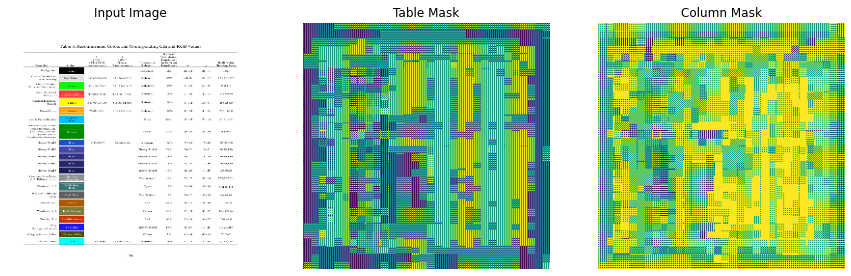

In [76]:
show_predictions(num=1)

#### Importing the clear_output library for display. Defined model checkpoint and early stopping callbacks for model training.

In [77]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="model/model_{epoch:02d}.keras",
        #filepath="model/model_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        verbose=1,
    )

In [78]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), {'table_output': TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), 'column_output': TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)})>

In [79]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), {'table_output': TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), 'column_output': TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)})>

# 5. TEM Model Training
Training a deep learning model using TensorFlow/Keras for a machine learning task using the 'fit' method with  parameters including training and validation datasets, number of epochs, steps per epoch, validation steps, and callbacks for displaying progress, model checkpointing, and early stopping.

1/1 [==============================] - 1s 745ms/step


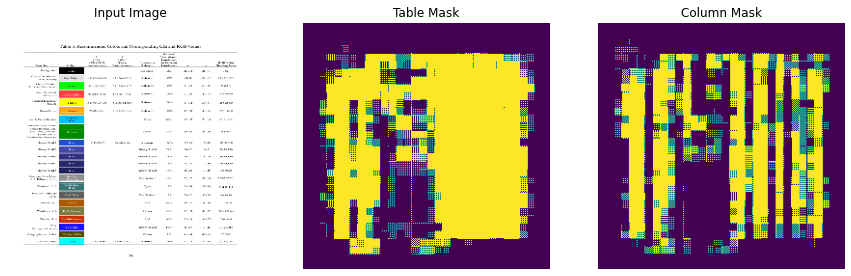


Sample Prediction after epoch 25


Epoch 25: val_loss did not improve from 0.25576
222/222 [==============================] - 231s 1s/step - loss: 0.3436 - table_output_loss: 0.1666 - column_output_loss: 0.1770 - table_output_accuracy: 0.9254 - column_output_accuracy: 0.9032 - val_loss: 0.4459 - val_table_output_loss: 0.2026 - val_column_output_loss: 0.2433 - val_table_output_accuracy: 0.9076 - val_column_output_accuracy: 0.8611


In [80]:
EPOCHS = 25
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS

try:
    model_history = model.fit(train_dataset, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_dataset,
                              callbacks=[DisplayCallback(), model_checkpoint, early_stoping],
                             )
except tf.errors.NotFoundError as e:
    print(f"Ignoring NotFoundError during training: {e}")


1/1 [==============================] - 1s 675ms/step


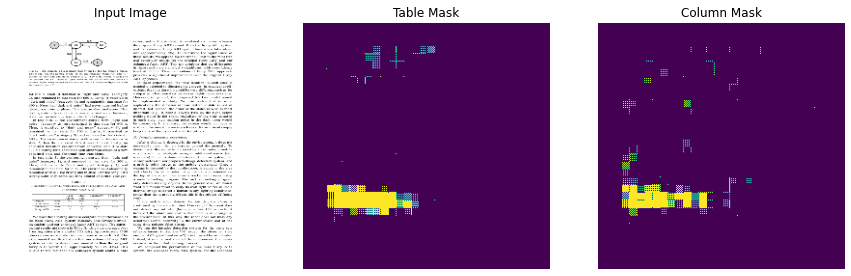

1/1 [==============================] - 1s 694ms/step


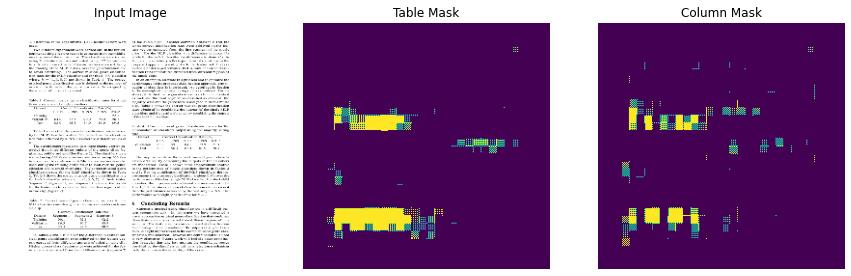

1/1 [==============================] - 1s 857ms/step


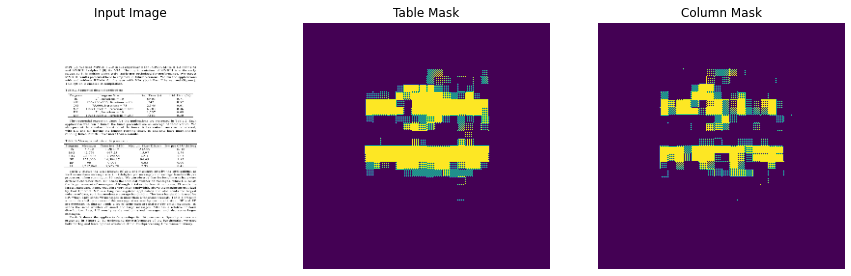

1/1 [==============================] - 1s 704ms/step


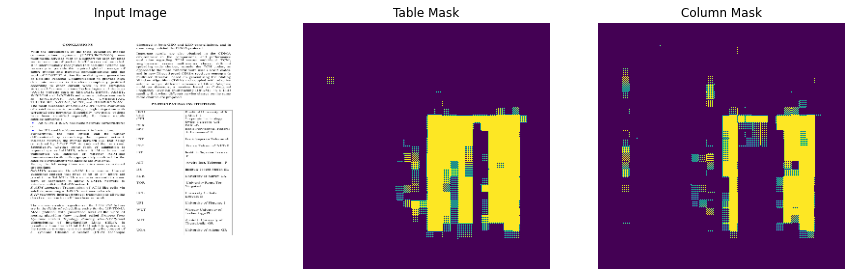

1/1 [==============================] - 1s 663ms/step


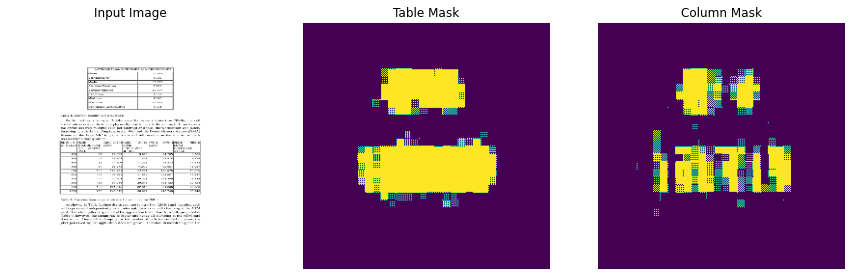

In [81]:
show_predictions(train_dataset, 5)

1/1 [==============================] - 1s 775ms/step


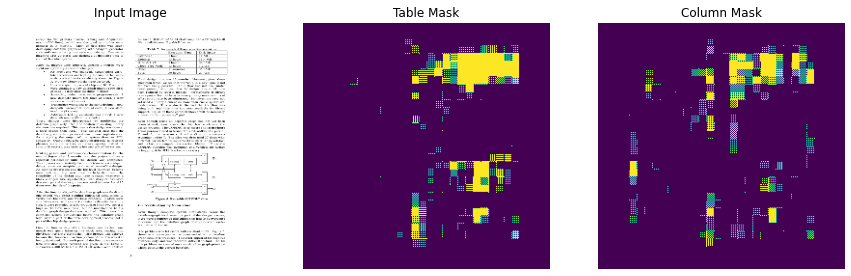

1/1 [==============================] - 1s 705ms/step


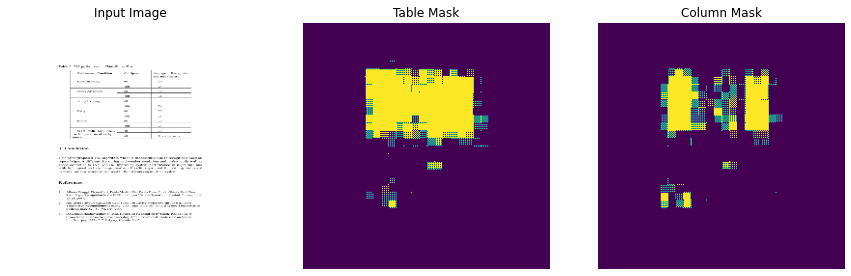

1/1 [==============================] - 1s 685ms/step


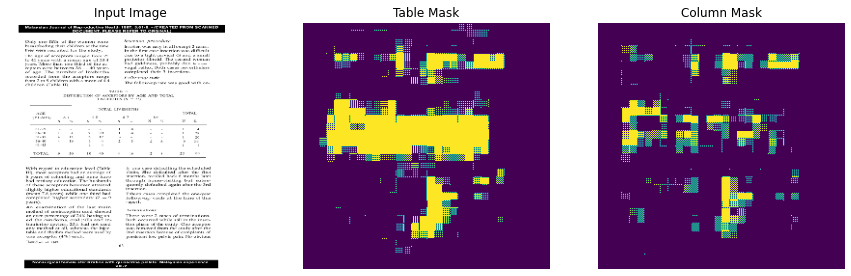

1/1 [==============================] - 1s 708ms/step


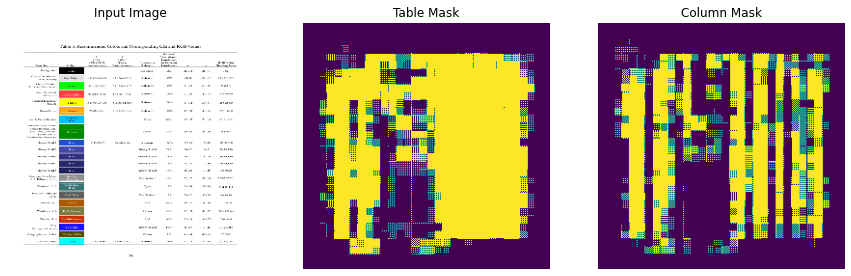

1/1 [==============================] - 1s 712ms/step


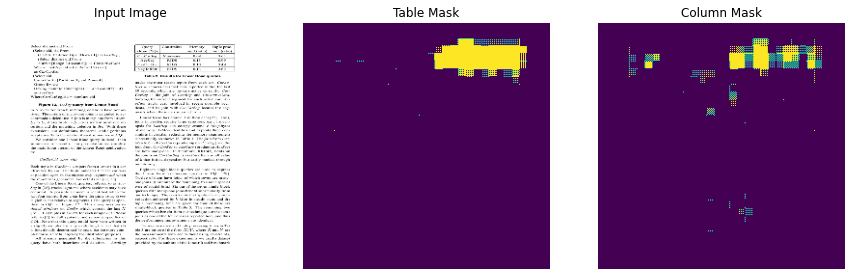

In [82]:
show_predictions(test_dataset, 5)

In [83]:
model.save('best_model.keras')

# 6. Table Extraction 

#### Installing the libraries required for extraction

In [84]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr
!pip install opencv-python
!pip install FPDF
!pip install pandas
!pip install reportlab

DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
'sudo' is not recognized as an internal or external command,
operable program or batch file.


DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


DEPRECATION: nb-black 1.0.7 has a non-standard dependency specifier black>='19.3'. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of nb-black or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Tested the pystract library for a sample image

Country
1 Australia

2 France
3 Chile
4 Italy
5 Spain

6 — United States
7 Argentina

8 Portugal

9 South Africa

10 Germany

Value for 2019 (RMB) in Millions
5,984

4,850
2,385
1,079
1,002
266
188
171
155

154




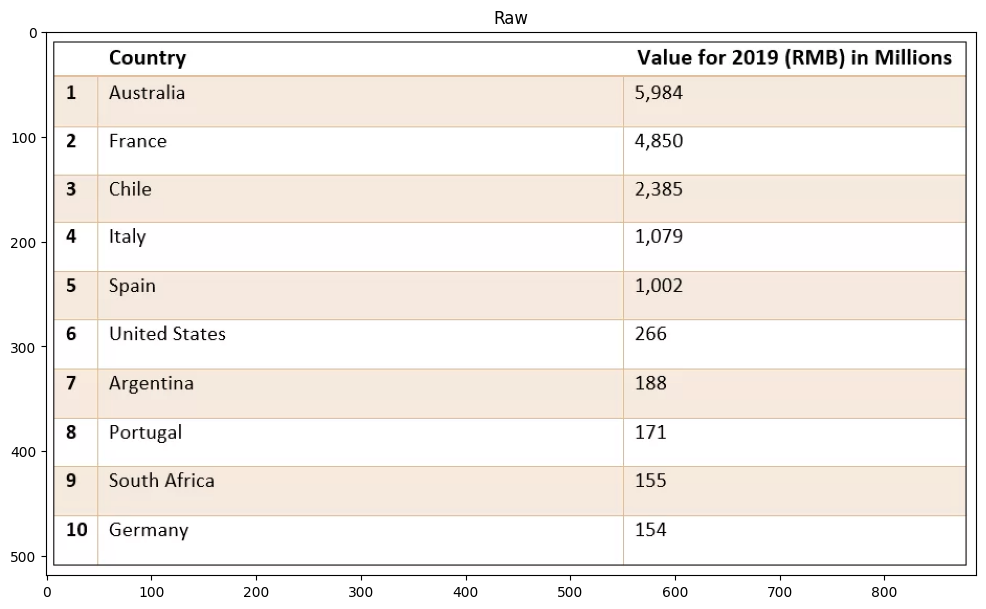

In [85]:
import cv2
import pytesseract
from itertools import repeat
import csv
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt


def extract(test_file_path, output_csv_path, output_text_path):
	image = cv2.imread(test_file_path)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

	# Repair horizontal table lines 
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
	thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

	# Remove horizontal lines
	horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (55,2))
	detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
	cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if len(cnts) == 2 else cnts[1]
	for c in cnts:
		cv2.drawContours(image, [c], -1, (255,255,255), 9)

	# Remove vertical lines
	vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,55))
	detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
	cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if len(cnts) == 2 else cnts[1]
	for c in cnts:
		cv2.drawContours(image, [c], -1, (255,255,255), 9)

	# # Show image
	plt.figure(figsize=(12, 8), dpi=100)
	plt.title('Raw Image vs Processed Image')
	# # plt.suptitle(f'Sample {idx:04d}')
	# plt.subplot(1, 2, 1)
	plt.title('Raw')
	plt.imshow(image)
	# OCR 
	pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
	try:
		data = pytesseract.image_to_string(Image.open('dataset/test_data/sample2.png'))
		print(data)
		with open(output_text_path, "w+") as f:
			f.write(data)
	except pytesseract.TesseractNotFoundError as e:
			print(f"Tesseract not found: {e}")
	except pytesseract.TesseractError as e:
			print(f"Tesseract error: {e}")


	with open(output_text_path, 'r') as in_file:
		stripped = (line.strip() for line in in_file)
		lines = (line.split("|") for line in stripped if line)
		with open(output_csv_path, 'w') as out_file:
			writer = csv.writer(out_file)
			writer.writerow((' ', ' '))
			writer.writerows(lines)

# from script.text_extract import extract
extract("dataset/test_data/sample2.png", "dataset/test_data/sample_text.csv", "dataset/test_data/sample_text.txt")

#### Function to extracts text from image,transposing it, and organizing into CSV for structured data analysis.

In [86]:
import cv2
import pytesseract
import os
import csv
import xml.etree.ElementTree as ET

def generate_output(image_path, output_text_csv):
    def get_xml_path(image_path):
        directory, filename = os.path.split(image_path)
        filename_without_extension, _ = os.path.splitext(filename)
        return os.path.join(directory, f"{filename_without_extension}.xml")

    def starts_with_capital(text):
        # Check if the first character of the text is a capital letter
        return text and text[0].isupper()

    # Read the image
    original_image = cv2.imread(image_path)
    xml_file_path = get_xml_path(image_path)
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
    except FileNotFoundError:
        print(f"Error: XML file not found for {image_path}")
        return

    # Create a list to store rows of extracted text
    rows_of_text = []

    # Iterate through each object in the XML
    for idx, obj in enumerate(root.findall('.//object')):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Extract the region of interest (ROI) from the original image
        roi = original_image[ymin:ymax, xmin:xmax]

        # Convert the ROI to grayscale
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Perform OCR on the ROI
        text = pytesseract.image_to_string(gray_roi)
        print("text is", text)

        # Split the text based on empty lines and capital letters
        lines = []
        current_line = ""
        for line in text.split('\n'):
            if not line:
                # Skip empty lines
                continue

            if starts_with_capital(line):
                # Start a new line if the current line starts with a capital letter
                if current_line:
                    lines.append(current_line.strip())
                current_line = line
            else:
                # Continue appending to the current line
                current_line += ' ' + line

        # Add the last line
        if current_line:
            lines.append(current_line.strip())

        # Update the rows_of_text list with the extracted lines
        if idx >= len(rows_of_text):
            rows_of_text.append([])

        rows_of_text[idx].extend(lines)

        # Print the extracted text for each region
        print(f"Extracted Text for {name} (Column {idx}):")
        print(lines)

    with open(output_text_csv, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Write header row with column names
        csv_writer.writerow([f'Column_{i}' for i in range(len(rows_of_text))])

        # Write rows with extracted text
        for line_idx in range(max(len(column) for column in rows_of_text)):
            row_data = [column[line_idx] if line_idx < len(column) else '' for column in rows_of_text]
            csv_writer.writerow(row_data)


#### Passed the image path to be processed and output path for csv

In [87]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
image_path = 'dataset/Marmot_data/10.1.1.1.2034_8.bmp'
output_text_csv = 'dataset/output_generated_with_table_format.csv'

generate_output(image_path, output_text_csv)

text is ‘Component

Load balancing
Application laye
Service layer

Failure manage-
ment

Worker place-
ment

User profile
(ACID) databas

Caching

Extracted Text for column (Column 0):
['‘Component', 'Load balancing', 'Application laye', 'Service layer', 'Failure manage- ment', 'Worker place- ment', 'User profile (ACID) databas', 'Caching']
text is ‘TranSend

Dynami, by queue
lengths at worker
nodes

omposable TACC
workers

Worker dispateh
ogic, HTML / Java
Script UL
‘Centralized but
fulttolerant using
process-peets
FE'S and caches
und to their nodes

Berkeley DB with
read caches

Harvest caches
tote pre-and post-
ransformation Web

data

Extracted Text for column (Column 1):
['‘TranSend', 'Dynami, by queue lengths at worker nodes omposable TACC workers', 'Worker dispateh ogic, HTML / Java', 'Script UL ‘Centralized but fulttolerant using process-peets', "FE'S and caches und to their nodes", 'Berkeley DB with read caches', 'Harvest caches tote pre-and post- ransformation Web data']
text

#### Converted the csv file to pdf for comparison

In [88]:
import os
import pandas as pd
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def wrap_text(text, max_words_per_line):
    words = text.split()
    lines = [' '.join(words[i:i+max_words_per_line]) for i in range(0, len(words), max_words_per_line)]
    return '\n'.join(lines)

# Read CSV file
csv_file = 'dataset/output_generated_with_table_format.csv'

try:
    df = pd.read_csv(csv_file)

    # Replace NaN values with empty space
    df = df.fillna('')

    # Output PDF file name
    pdf_output = 'dataset/output_generated_with_table_format_reportlab.pdf'
    
    # Create PDF
    c = canvas.Canvas(pdf_output, pagesize=letter)
    
    # Set font and font size (adjust the size as needed)
    c.setFont("Helvetica", size=8)

    # Add title
    c.drawCentredString(300, 750, "")

    # Define total columns and rows
    total_columns = len(df.columns)
    total_rows = len(df)

    # Calculate the width of the table to be equal to the page width
    table_width = letter[0] - 40  # Adjust as needed

    # Set the initial y-coordinate for the table
    y = 700

    # Set the maximum words per line
    max_words_per_line = 6

    # Set the height of each cell
    cell_height = 40  # Adjust as needed
    cell_padding = 12    # Adjust as needed

    # Iterate through rows and columns to populate PDF
    for _, row in df.iterrows():
        # Move to the starting position horizontally for each row
        x = 20

        for _, col in enumerate(df.columns):
            cell_value = str(row[col])

            if len(cell_value.split()) > max_words_per_line:
                # Wrap text to the next line within the same cell
                cell_value = wrap_text(cell_value, max_words_per_line)

            # Set the cell width based on your requirements
            cell_width = table_width / total_columns

            
            c.rect(x, y, cell_width, -cell_height, fill=False)

            
            text_object = c.beginText(x + cell_padding, y - cell_padding)
            text_object.setFont("Helvetica", size=8)
            text_object.setTextOrigin(x + cell_padding, y - cell_padding)
            text_object.textLines(cell_value)
            text_height = text_object.getY() - (y - cell_height + cell_padding)

            
            c.drawText(text_object)

            x += cell_width

        
        y -= max(cell_height, text_height)

    # Save the PDF
    c.save()

    print(f"PDF successfully created: {pdf_output}")

except Exception as e:
    print(f"Error: {e}")


PDF successfully created: dataset/output_generated_with_table_format_reportlab.pdf
